## 准备工作

### 导入库

In [1]:
import sys
sys.path.append("..")
import os
import torch
import torch.nn as nn
import torchpal as tp
import pandas as pd

### 准备数据

In [2]:
NUM_TRAIN_SAMPLES = 500
NUM_TEST_SAMPLES = 100
NUM_FEATURES = 10

# 实际使用中，应确保数据已进行必要的预处理
# 训练集
train_df = pd.DataFrame(
    {"id": range(NUM_TRAIN_SAMPLES)} | 
    {"feature_" + str(i): torch.randn(NUM_TRAIN_SAMPLES) for i in range(NUM_FEATURES)}
)
X_train = torch.tensor(train_df.drop(columns=["id"]).values)
y_train = ((X_train[:, 0] > 0).long() + (X_train[:, 1] > 0).long()).reshape(-1,1)        # 假设只跟前2个特征有关，分成0，1，2三类
# 测试集
test_df = pd.DataFrame(
    {"id": range(NUM_TEST_SAMPLES)} | 
    {"feature_" + str(i): torch.randn(NUM_TEST_SAMPLES) for i in range(NUM_FEATURES)}
)  # 注意：test_df 的创建仅为示例，实际应加载你的测试集 DataFrame，例如：pd.read_csv("test.csv")
X_test = torch.tensor(test_df.drop(columns=["id"]).values)

### 定义你自己的模型

In [3]:
class MyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),  
        )

    def forward(self, X):
        return self.net(X)

## 调用 torchpal

In [4]:
# 初始化 torchpal 管理器
manager = tp.train.ClassificationManager(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    net_cls=MyModel,
    net_params={"input_dim": X_train.shape[1], "hidden_dim": 64, "output_dim": 3},  # 3分类
    criterion_cls=nn.CrossEntropyLoss,
    criterion_params={},
    optimizer_cls=torch.optim.Adam,
    optimizer_params={"lr": 0.005, "weight_decay": 0.01},
    # device="cpu" # 如果不支持cuda，请取消注释此行
)

--- 探索性训练 ---
检测到weight_decay，已自动临时视作0以屏蔽该参数


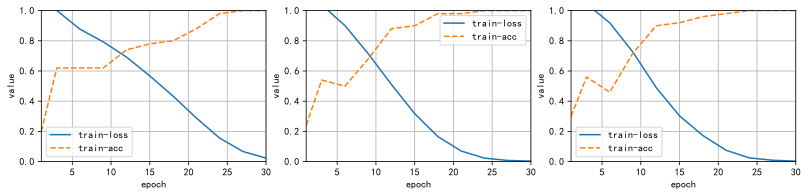

<Figure size 640x480 with 0 Axes>

In [5]:
# 探索性训练：在小数据集上快速验证
print("--- 探索性训练 ---")
manager.exploratory_train(subset_size=50, num_epochs=30, ylim=(0, 1))


--- K 折交叉验证 ---


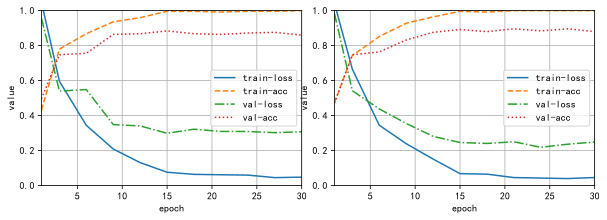

<Figure size 640x480 with 0 Axes>

In [6]:
# 训练与评估。（支持 K 折交叉验证）
print("\n--- K 折交叉验证 ---")
manager.train_and_eval(k_folds=2, batch_size=32, num_epochs=30, ylim=(0, 1))

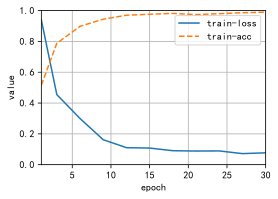

训练完成，已返回模型


<Figure size 640x480 with 0 Axes>

In [7]:
# 最终训练：在完整训练集上训练
final_model = manager.final_train(batch_size=32, num_epochs=30, ylim=(0, 1))

In [8]:
# 预测并保存结果
predictions = manager.predict(
    model=final_model,
    test_df=test_df,  # 包含 ID 列的 DataFrame
    pred_col_name="target",  # 预测列名
    backup_src_path='./test_classification.ipynb',  # 提供路径以备份模型
    # device="cpu"
)

模型：
model=MyModel(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
)
预测的结果已保存到 d:\Workspace\Vscode\Repos\torchpal\test\submissions\MyModel_0509_131752_pred.csv
Source file backed up to: d:\Workspace\Vscode\Repos\torchpal\test\backups\test_classification_0509_131752.ipynb


In [12]:
def check_pred_acc():
    path = r"d:\Workspace\Vscode\Repos\torchpal\test\submissions\MyModel_0509_131752_pred.csv"
    df = pd.read_csv(path)
    y_pred = torch.tensor(df.iloc[:, 1].values).long()
    y_test = (X_test[:, 0] > 0).long() + (X_test[:, 1] > 0).long()
    print((y_pred == y_test).sum().item() / len(y_pred))


check_pred_acc()

0.93


## 附：其他功能

### 自定义评估指标

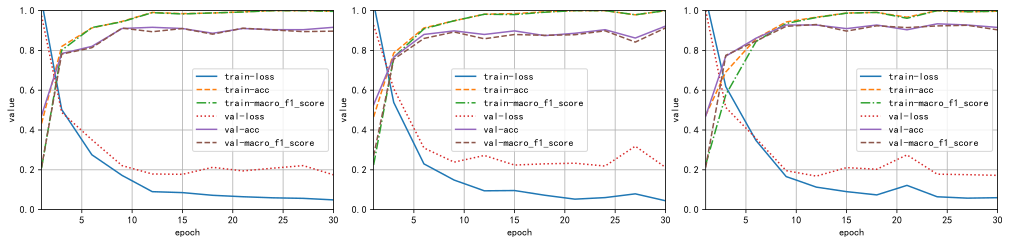

<Figure size 640x480 with 0 Axes>

In [13]:
import torch

def macro_f1_score(logits: torch.Tensor, labels: torch.Tensor) -> float:
    """
    计算多分类任务的宏平均F1分数。

    参数:
    logits (torch.Tensor): 模型的原始输出 (未经过softmax)，形状为 (N, C)，
                           N是样本数量，C是类别数量。
    labels (torch.Tensor): 真实的标签，形状为 (N, 1)，每个元素是类别索引。

    返回:
    float: 宏平均F1分数。
    """
    if not isinstance(logits, torch.Tensor) or not isinstance(labels, torch.Tensor):
        raise TypeError("输入 logits 和 labels 必须是 torch.Tensor 类型。")
    if logits.ndim != 2:
        raise ValueError(f"输入 logits 应该是2维的 (N, C)，但得到的是 {logits.ndim}维。")
    if labels.ndim != 2:
        raise ValueError(f"输入 labels 应该是2维的 (N, 1)，但得到的是 {labels.ndim}维。")
    if logits.shape[0] != labels.shape[0]:
        raise ValueError(f"logits 和 labels 的样本数量（第0维）必须一致，但得到 logits: {logits.shape[0]} 和 labels: {labels.shape[0]}。")


    labels = labels.squeeze()
    # 获取预测类别
    preds = torch.argmax(logits, dim=1)
    
    num_classes = logits.shape[1]
    if num_classes == 0:
        return 0.0
        
    f1_scores_per_class = []

    for i in range(num_classes):
        # 针对类别 i:
        # True Positives (TP): 实际为类别 i，且被正确预测为类别 i 的样本数
        tp = ((preds == i) & (labels == i)).sum().item()
        
        # False Positives (FP): 实际不是类别 i，但被错误预测为类别 i 的样本数
        fp = ((preds == i) & (labels != i)).sum().item()
        
        # False Negatives (FN): 实际为类别 i，但被错误预测为其他类别的样本数
        fn = ((preds != i) & (labels == i)).sum().item()

        # 计算精确率
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        # 计算召回率
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        # 计算F1分数
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        f1_scores_per_class.append(f1)

    # 计算宏平均F1分数
    macro_f1 = sum(f1_scores_per_class) / num_classes if num_classes > 0 else 0.0
    
    return macro_f1


# 在训练/评估时通过 metric_names 传入自定义指标函数变量 "mae".（"loss", "acc"是内置的特殊名字）
manager.train_and_eval(k_folds=3, batch_size=32, num_epochs=30, metric_names=["loss","acc", macro_f1_score])  